In [42]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `~/logic-and-machine-learning`


In [43]:
using Random

Random.seed!(1235)

TaskLocalRNG()

### Many-Expert Decision Trees

`ManyExpertDecisionTrees.jl` is still in development and has not been released
yet!

In [44]:
using ManyExpertDecisionTrees

"Many-Expert Decision Trees" sounds like a very general name...

Let's start with some motivation (and only one expert):
- we want to move from "hard" to "soft" decisions
- we want a better treatment of uncertainty

How will we achieve that?
- evaluating all the branches in our tree, and choosing the one(s) with higher
values - i.e., we do not comply to one, strict, crisp decision at each step,
but we take into consideration the contribution of each node
- for each node, we won't have that a feature is "true" or "false"; rather, we
will assign a value between 0 and 1, and combine these values using the t-norm
- at the end, we do not constrain the model to always give a (single) class - 
it can also say "I do not know which class, but """surely""" (for the model) it
is between those classes"

Let's load, once again, the "iris" dataset.

In [45]:
using RDatasets # used to load the iris dataset

data = RDatasets.dataset("datasets", "iris");

In [46]:
using MLJ

y, X = unpack(data, ==(:Species));

And let's split out data into training and test.

In [47]:
(X_train, X_test), (y_train, y_test) = partition(
    (X, y),
    0.8,
    rng=13,
    shuffle=true,
    multi=true
);

Our approach works in the following way:
- we will further divide our training dataset into n+1 slices, were n is the
number of experts (in this first example, just one - so we'll have 2 slices)
- then, we will learn a classical (crisp) decision tree, using the first slice
of the training set
- finally, we will use each of the other `n` slices to train some parameters
characterising a "soft" version of the learnt decision tree

In [48]:
(X_train_dt, X_train_exp), (y_train_dt, y_train_exp) = partition(
    (X_train, y_train),
    0.4,
    rng=42,
    shuffle=true,
    multi=true
);

Let's build a classical (crisp) decision tree on the first slice.

(Remember: we already shuffled out instances when splitting into train/test)

In [49]:
using DecisionTree

# Build a standard decision tree (explicitly)
dt = build_tree(y_train_dt, Matrix(X_train_dt))

Decision Tree
Leaves: 5
Depth:  4

In [50]:
# Prune tree: merge leaves having >= 90% combined purity
dt = prune_tree(dt, 0.9)

Decision Tree
Leaves: 5
Depth:  4

In [51]:
print_tree(dt)

Feature 4 < 0.75 ?
├─ setosa : 15/15
└─ Feature 3 < 4.9 ?
    ├─ Feature 4 < 1.7 ?
        ├─ versicolor : 14/14
        └─ Feature 2 < 3.1 ?
            ├─ virginica : 1/1
            └─ versicolor : 1/1
    └─ virginica : 17/17


In [52]:
y_pred = apply_tree(dt, Matrix(X_test));

In [53]:
cm = confusion_matrix(y_test, y_pred)

           ┌────────────────────────────────┐
           │          Ground Truth          │
┌──────────┼──────────┬──────────┬──────────┤
│Predicted │  setosa  │versicol… │virginica │
├──────────┼──────────┼──────────┼──────────┤
│  setosa  │    12    │    0     │    0     │
├──────────┼──────────┼──────────┼──────────┤
│versicol… │    0     │    6     │    3     │
├──────────┼──────────┼──────────┼──────────┤
│virginica │    0     │    0     │    9     │
└──────────┴──────────┴──────────┴──────────┘


In [54]:
accuracy(cm)

0.9

Let's try to soften this decision tree!

First, we need to define a new structure (we need to add more information about
each node of our decision tree); namely, a `ManyExpertDecisionTree`.

Not only that: we need to specify a `ManyExpertAlgebra` (more on that in a
minute!) specifying a fuzzy logic to use for each expert.

In [55]:
using SoleLogics.ManyValuedLogics

mxa = ManyExpertAlgebra(ProductLogic)

ManyExpertAlgebra with 1 expert:
  [1] FuzzyLogic(t-norm: Product (*))

The idea is to soften the original decision tree treating each node as a
"membership" to a "fuzzy set" (note that if we use only `true` and `false`, we
obtain the original split).

Hence, we will leverage membership functions, associating one for each node to
each expert.

For membership functions, we will leverage the `FuzzyLogic.jl` package.

Watch out! Even if it is called `FuzzyLogic.jl`, this package offers classical
tools (like membership functions) to work with fuzzy sets and system, and it is
NOT a package to manipulate mathematical fuzzy logic.

Moreover, since we already have `FuzzyLogic` as a type in our naming space, we
provide an alias to load the package, as follows.

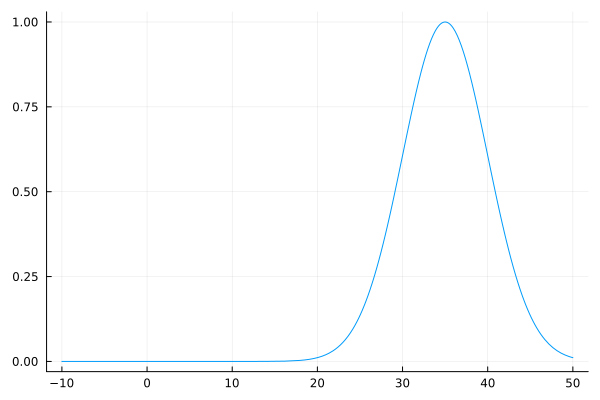

In [56]:
using ManyExpertDecisionTrees: FL   # This is an alias for `FuzzyLogic.jl`
using Plots

hot = FL.GaussianMF(35.0, 5.0)  # temp>25
plot(hot, -10, 50)

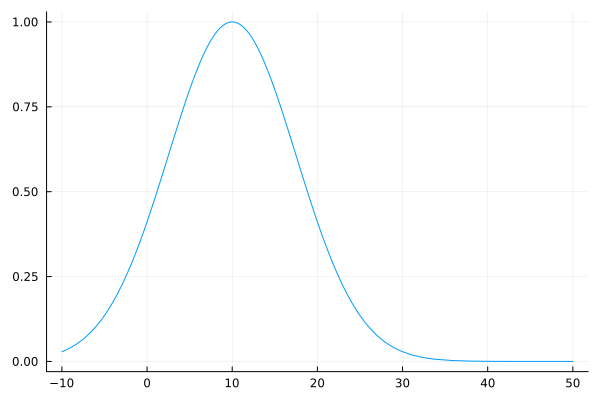

In [57]:
cold = FL.GaussianMF(10.0, 7.5) # temp≤25
plot(cold, -10, 50)

In [58]:
hot(32)

0.835270211411272

In [59]:
cold(32)

0.013538440136652357

In [60]:
hot(12)

2.5419346516199247e-5

In [61]:
cold(12)

0.9650691177896804

In [62]:
hot(25)

0.1353352832366127

In [63]:
cold(25)

0.1353352832366127

To soften the decision tree, we use the manify function, specifying:
- the original decision tree
- the portion of the training set to use
- a tuple of kind of "membership functions" to use (one for each expert)

The parameters I'm learning are the parameters of the chosen
function; in our case, we will only use Gaussian functions.

In [64]:
medt = manify(dt, X_train_exp, (FL.GaussianMF))

Many-Expert DecisionTree Root
Experts: DataType[FuzzyLogic.GaussianMF{Float64}]


In [65]:
y_pred_mxa = map(eachrow(X_test)) do row
    result = ManyExpertDecisionTrees.apply(
        medt,
        mxa,
        Vector{Float64}(row)
    )
    return length(result) != 1 ? :vague : first(result)
end;

In [66]:
n_total = length(y_test)

n_correct = count(i -> y_pred_mxa[i] == y_test[i], 1:n_total)
(n_correct / n_total) * 100

93.33333333333333

In [67]:
n_vague = count(==(:vague), y_pred_mxa)
(n_vague / n_total) * 100


0.0

In [68]:
n_wrong = n_total - n_correct - n_vague
(n_wrong / n_total) * 100

6.666666666666667

Wow, this was lucky! This improved performance!

Probably, the heuristic didn't choose the "best" attribute at each step: with
softening, we can make up for it!

Now, let's try to use more than one expert!

In [69]:
# Since we'd need to further split our data between experts, let's give them
# a bigger slice!
(X_train_dt, X_train_exp), (y_train_dt, y_train_exp) = partition(
    (X_train, y_train),
    0.2,
    rng=42,
    shuffle=true,
    multi=true
);

In [70]:
# Build a standard decision tree (explicitly)
dt = build_tree(y_train_dt, Matrix(X_train_dt))
# Prune tree: merge leaves having >= 90% combined purity
dt = prune_tree(dt, 0.9)
print_tree(dt)

Feature 4 < 0.75 ?
├─ setosa : 7/7
└─ Feature 3 < 4.9 ?
    ├─ Feature 3 < 4.7 ?
        ├─ versicolor : 5/5
        └─ Feature 1 < 5.95 ?
            ├─ versicolor : 1/1
            └─ virginica : 1/1
    └─ virginica : 10/10


In [71]:
# Evaluate performance (crisp decision tree)
y_pred = apply_tree(dt, Matrix(X_test));
cm = confusion_matrix(y_test, y_pred);
accuracy(cm)

0.8333333333333334

We will use 2 experts: one characterised by `ProductLogic`, the second by
`GodelLogic`.

**What is `ManyExpertAlgebra`?** Now we can answer this question (but not mind
too much about it - if it's confusing, skip this part): it is a product of
fuzzy logics!

The result is a many-valued logic, characterised by partially ordered tuples.

In [72]:
# Algebra characterising each expert
mxa = ManyExpertAlgebra(ProductLogic, GodelLogic)

ManyExpertAlgebra with 2 experts:
  [1] FuzzyLogic(t-norm: Product (*))
  [2] FuzzyLogic(t-norm: Gödel (min))

In [73]:
# Manify decision tree
medt = manify(dt, X_train_exp, FL.GaussianMF, FL.GaussianMF)

Many-Expert DecisionTree Root
Experts: DataType[FuzzyLogic.GaussianMF{Float64}, FuzzyLogic.GaussianMF{Float64}]


In [74]:
# Evaluate performance (many-expert decision tree)
y_pred_mxa = map(eachrow(X_test)) do row
    result = ManyExpertDecisionTrees.apply(
        medt,
        mxa,
        Vector{Float64}(row)
    )
    return length(result) != 1 ? :vague : first(result)
end;

In [75]:
n_correct = count(i -> y_pred_mxa[i] == y_test[i], 1:n_total)
(n_correct / n_total) * 100

86.66666666666667

In [76]:
n_vague = count(==(:vague), y_pred_mxa)
(n_vague / n_total) * 100

3.3333333333333335

In [77]:
n_wrong = n_total - n_correct - n_vague
(n_wrong / n_total) * 100

10.0

Not only we slightly improved our performance...

We also reduced wrong predictions, in favor of "uknowns": this is important,
especially in critical scenarios!

For instance, suppose we are predicting if it's safe to travel by plane on a
specific day, based on weather forecasting: with a crisp decision tree, I would
have an error of 17%!

Instead, if I know it's unsure, if it's safe or not, I can default to
"it is not", hence, my error is only 10%.

This is good, even at the risk of loosing some accuracy: better be safe than
sorry!

The following cell represents a simple experiment, comparing various
combinations of experts on the `iris` dataset.

In [78]:
using Combinatorics

allexperts = (GodelLogic, LukasiewiczLogic, ProductLogic);

# Compute all possible expert compbinations (with replacement)
expertcomb = begin
    c = Vector{Vector{FuzzyLogic}}()
    for i in 1:length(allexperts)
        append!(
            c,
            collect(Combinatorics.with_replacement_combinations(allexperts, i))
        )
    end
    c
end;

# This is useful to read results later 
expertcombreadable = map(expertcomb) do experts
    result = ""
    for expert in experts
        if (expert === GodelLogic)
            result *= "G"
        end
        if (expert === LukasiewiczLogic)
            result *= "L"
        end
        if (expert === ProductLogic)
            result *= "P"
        end
    end

    return result
end;

correct = [[0.0, 0.0] for _ in 1:length(expertcomb)];
wrong = [[0.0, 0.0] for _ in 1:length(expertcomb)];
vague = [[0.0, 0.0] for _ in 1:length(expertcomb)];

n_runs = 10

for i in 1:n_runs
    # Partition set into training and validation
    X_train, y_train, X_test, y_test = begin
        train, test = partition(eachindex(y), 0.8, shuffle=true, rng=i)
        X_train, y_train = X[train, :], y[train]
        X_test, y_test = X[test, :], y[test]
        X_train, y_train, X_test, y_test
    end

    # Build a standard decision tree
    dt = build_tree(y_train, Matrix(X_train))
    dt = prune_tree(dt, 0.9)

    # For each expert combination, build a ManyExpertDecisionTree 
    Threads.@threads for k in eachindex(expertcomb)
        mf_experts = ntuple(_ -> FL.GaussianMF, length(expertcomb[k]))
        MXA = ManyExpertAlgebra(expertcomb[k]...)

        medt = manify(dt, X_train, mf_experts...)

        y_pred = map(eachrow(X_test)) do row
            result = ManyExpertDecisionTrees.apply(
                medt,
                MXA,
                Vector{Float64}(row)
            )
            return length(result) != 1 ? :vague : first(result)
        end

        # Extrapolating statistics
        n_total = length(y_test)

        n_vague = count(==(:vague), y_pred)
        pvague = (n_vague / n_total) * 100

        n_correct = count(i -> y_pred[i] == y_test[i], 1:n_total)
        pcorrect = (n_correct / n_total) * 100

        n_wrong = n_total - n_correct - n_vague
        pwrong = (n_wrong / n_total) * 100

        deltacorrect = (pcorrect - correct[k][1])
        correct[k][1] += deltacorrect / i
        correct[k][2] += deltacorrect * (pcorrect - correct[k][1])

        deltawrong = (pwrong - wrong[k][1])
        wrong[k][1] += deltawrong / i
        wrong[k][2] += deltawrong * (pwrong - wrong[k][1])

        deltavague = (pvague - vague[k][1])
        vague[k][1] += deltavague / i
        vague[k][2] += deltavague * (pvague - vague[k][1])

    end
end

# Process results: extract means and compute standard deviations (sample std)
correct_mean = [x[1] for x in correct]
correct_std = [sqrt(x[2] / (n_runs - 1)) for x in correct]

wrong_mean = [x[1] for x in wrong]
wrong_std = [sqrt(x[2] / (n_runs - 1)) for x in wrong]

vague_mean = [x[1] for x in vague]
vague_std = [sqrt(x[2] / (n_runs - 1)) for x in vague]

df = DataFrame(
    experts=expertcombreadable,
    correct_mean=correct_mean,
    correct_std=correct_std,
    wrong_mean=wrong_mean,
    wrong_std=wrong_std,
    vague_mean=vague_mean,
    vague_std=vague_std
)

Row,experts,correct_mean,correct_std,wrong_mean,wrong_std,vague_mean,vague_std
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,G,95.3333,3.22031,3.66667,2.91865,1.0,2.24983
2,L,71.0,18.3955,6.0,4.66137,23.0,18.8856
3,P,94.3333,3.53117,5.66667,3.53117,0.0,0.0
4,GG,86.3333,5.97319,2.66667,3.44265,11.0,8.6138
5,GL,65.6667,21.2016,1.66667,2.35702,32.6667,22.0997
6,GP,88.0,5.01848,3.0,2.45955,9.0,5.88994
7,LL,64.3333,18.9899,5.0,4.23099,30.6667,20.1108
8,LP,70.0,17.3561,3.0,2.91865,27.0,19.0159
9,PP,93.0,4.28895,5.33333,2.81091,1.66667,2.35702


**Exercise**: play some more with the iris dataset, trying different
combinations of experts. Which is the one that works better?

**Exercise**: put into practice what you learned using the following dataset!

In [79]:
using CSV
using DataFrames

PENGUINS_PATH = joinpath("..", "datasets", "penguins.csv")
data = DataFrame(CSV.File(PENGUINS_PATH))

Row,rownames,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
,Int64,String15,String15,Float64?,Float64?,Int64?,Int64?,String7?,Int64
1,1,Adelie,Torgersen,39.1,18.7,181,3750,male,2007
2,2,Adelie,Torgersen,39.5,17.4,186,3800,female,2007
3,3,Adelie,Torgersen,40.3,18.0,195,3250,female,2007
4,4,Adelie,Torgersen,missing,missing,missing,missing,missing,2007
5,5,Adelie,Torgersen,36.7,19.3,193,3450,female,2007
6,6,Adelie,Torgersen,39.3,20.6,190,3650,male,2007
7,7,Adelie,Torgersen,38.9,17.8,181,3625,female,2007
8,8,Adelie,Torgersen,39.2,19.6,195,4675,male,2007
9,9,Adelie,Torgersen,34.1,18.1,193,3475,missing,2007


We need a bit of data preprocessing...

(We will see more about it tomorrow!)

In [80]:
using Impute

data_nomissing = Impute.filter(data; dims=:rows);

In [81]:
schema(data_nomissing)

┌───────────────────┬────────────┬──────────┐
│ names             │ scitypes   │ types    │
├───────────────────┼────────────┼──────────┤
│ rownames          │ Count      │ Int64    │
│ species           │ Textual    │ String15 │
│ island            │ Textual    │ String15 │
│ bill_length_mm    │ Continuous │ Float64  │
│ bill_depth_mm     │ Continuous │ Float64  │
│ flipper_length_mm │ Count      │ Int64    │
│ body_mass_g       │ Count      │ Int64    │
│ sex               │ Textual    │ String7  │
│ year              │ Count      │ Int64    │
└───────────────────┴────────────┴──────────┘


In [82]:
data_drop_cols = select!(data_nomissing, Not(:island, :sex))

Row,rownames,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
,Int64,String15,Float64,Float64,Int64,Int64,Int64
1,1,Adelie,39.1,18.7,181,3750,2007
2,2,Adelie,39.5,17.4,186,3800,2007
3,3,Adelie,40.3,18.0,195,3250,2007
4,5,Adelie,36.7,19.3,193,3450,2007
5,6,Adelie,39.3,20.6,190,3650,2007
6,7,Adelie,38.9,17.8,181,3625,2007
7,8,Adelie,39.2,19.6,195,4675,2007
8,13,Adelie,41.1,17.6,182,3200,2007
9,14,Adelie,38.6,21.2,191,3800,2007
